Во всех задачах нужно визуализировать минимальный путь и вывести его длину. 
Путь не циклический - начинается и заканчивается в разных точках.

ВНИМАНИЕ: расстояние нужно считать как L1, отрисовывать тоже как L1.

1. (1 балл) Реализуйте Монте-Карло поиск.
2. (1 балл) Реализуйте поиск случайным блужданием.
3. (2 балла) Реализуйте Hill Climb.
4. (3 балла) Реализуйте ожиг (simulated annealing). Температурный режим отжига выберите самостоятельно.
5. (3 балла) Реализуйте генетический алгоритм. 

### Считывание данных

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [4]:
df = pd.read_csv('../datasets/tsp.csv', index_col='index')

### Вспомогательные функции

In [40]:
def calc_dist(sample):
    tempory_df = df.iloc[sample]
    xx, yy = np.diff(tempory_df['x']), np.diff(tempory_df['y'])
    return sum(np.abs(xx) + np.abs(yy))

def montecarlo(n_steps):
    best_solution, best_score = [], float('inf')
    
    for step in range(n_steps):
        sample = random.sample(range(0, 52), k=52)
        current_score = calc_dist(sample)
        if current_score < best_score:
            best_solution, best_score = sample, current_score
    return best_solution, best_score

def random_search(n_steps):
    way = [i for i in range(52)]
    best_solution, best_score = [], float('inf') 
    
    for step in range(n_steps):
        left, right = random.randint(0, 51), random.randint(0, 51)
        way[left], way[right] = way[right], way[left]
        current_score = calc_dist(way)
        if current_score < best_score:
            best_solution, best_score = way[::], current_score
    
    return best_solution, best_score

def hill_climb(n_steps):
    way = [i for i in range(52)]
    best_solution, best_score = [], float('inf') 
    
    for step in range(n_steps):
        for i in range(len(way)):
            for j in range(i, len(way)):
                tmp_way = way[::]
                tmp_way[i], tmp_way[j] = tmp_way[j], tmp_way[i]
                current_score = calc_dist(tmp_way)
                if current_score < best_score:
                    best_score, best_solution = current_score, tmp_way
        way = best_solution
    return way, best_score

def annealing(n_steps):
    way = [i for i in range(52)]
    current_score, initial_t, t_step = float('inf'), 100, 100/n_steps
    
    while initial_t > 0:
        left, right = random.randint(0, 51), random.randint(0, 51)
        tempory_way = way[::]
        tempory_way[left:right] = tempory_way[left:right][::-1]
        new_score = calc_dist(tempory_way)
        if new_score < current_score:
            way = tempory_way[::]
            current_score = new_score
        
        elif random.random() < np.e ** ((current_score - new_score)/initial_t):
            way = tempory_way[::]
            current_score = new_score

        initial_t -= t_step
    
    return (way, current_score)

def genetic(n_steps):
    population = [np.random.permutation(52) for i in range(300)]
    for i in range(n_steps):
        population_scores = [calc_dist(individ) for individ in population]
        new_population = sorted(list(zip(population_scores, population)), key=lambda x: x[0])[:30]
        result_population = []
        pops = np.concatenate([population, list(map(lambda x: x[1], new_population))])
        for i in range(200):
            x,y = list(random.choice(pops)), list(random.choice(pops))
            child_1, child_2 = psmo(x, y)
            result_population.append(child_1)
            result_population.append(child_2)
        population = result_population[::]
    population_scores = [calc_dist(individ) for individ in population]
    return min(population_scores), population[population_scores.index(min(population_scores))]
    
def psmo(parent1, parent2):
    
    firstCrossPoint = np.random.randint(0,len(parent1)-2)
    secondCrossPoint = np.random.randint(firstCrossPoint+1,len(parent1)-1)


    parent1MiddleCross = parent1[firstCrossPoint:secondCrossPoint]
    parent2MiddleCross = parent2[firstCrossPoint:secondCrossPoint]

    temp_child1 = parent1[:firstCrossPoint] + parent2MiddleCross + parent1[secondCrossPoint:]

    temp_child2 = parent2[:firstCrossPoint] + parent1MiddleCross + parent2[secondCrossPoint:]

    relations = []
    for i in range(len(parent1MiddleCross)):
        relations.append([parent2MiddleCross[i], parent1MiddleCross[i]])


    def recursion1 (temp_child , firstCrossPoint , secondCrossPoint , parent1MiddleCross , parent2MiddleCross) :
        child = np.array([0 for i in range(len(parent1))])
        for i,j in enumerate(temp_child[:firstCrossPoint]):
            c=0
            for x in relations:
                if j == x[0]:
                    child[i]=x[1]
                    c=1
                    break
            if c==0:
                child[i]=j
        j=0
        for i in range(firstCrossPoint,secondCrossPoint):
            child[i]=parent2MiddleCross[j]
            j+=1

        for i,j in enumerate(temp_child[secondCrossPoint:]):
            c=0
            for x in relations:
                if j == x[0]:
                    child[i+secondCrossPoint]=x[1]
                    c=1
                    break
            if c==0:
                child[i+secondCrossPoint]=j
        child_unique=np.unique(child)
        if len(child)>len(child_unique):
            child=recursion1(child,firstCrossPoint,secondCrossPoint,parent1MiddleCross,parent2MiddleCross)
        return(child)

    def recursion2(temp_child,firstCrossPoint,secondCrossPoint,parent1MiddleCross,parent2MiddleCross):
        child = np.array([0 for i in range(len(parent1))])
        for i,j in enumerate(temp_child[:firstCrossPoint]):
            c=0
            for x in relations:
                if j == x[1]:
                    child[i]=x[0]
                    c=1
                    break
            if c==0:
                child[i]=j
        j=0
        for i in range(firstCrossPoint,secondCrossPoint):
            child[i]=parent1MiddleCross[j]
            j+=1

        for i,j in enumerate(temp_child[secondCrossPoint:]):
            c=0
            for x in relations:
                if j == x[1]:
                    child[i+secondCrossPoint]=x[0]
                    c=1
                    break
            if c==0:
                child[i+secondCrossPoint]=j
        child_unique=np.unique(child)
        if len(child)>len(child_unique):
            child=recursion2(child,firstCrossPoint,secondCrossPoint,parent1MiddleCross,parent2MiddleCross)
        return(child)

    child1=recursion1(temp_child1,firstCrossPoint,secondCrossPoint,parent1MiddleCross,parent2MiddleCross)
    child2=recursion2(temp_child2,firstCrossPoint,secondCrossPoint,parent1MiddleCross,parent2MiddleCross)

    return child1, child2

def plot_line(array_x, array_y):
    x_0, x_1, y_0, y_1 = *array_x, *array_y
    plt.plot([x_0, x_1], [y_0, y_0],c='b')
    plt.plot([x_1, x_1], [y_0, y_1],c='b')

def plot_solution(way, score):
    plt.figure(figsize=(25, 25))
    plt.scatter(df['x'], df['y'], label=f'Best distanse: {score}')
    
    for index in range(51):
        node_1, node_2 = df.iloc[way[index]], df.iloc[way[index + 1]]
        array_x, array_y = (node_1['x'], node_2['x']), (node_1['y'], node_2['y'])
        #plt.plot(array_x, array_y)
        plot_line(array_x, array_y)
    plt.legend(fontsize=32)

### Монте-Карло поиск

In [171]:
way, score = montecarlo(10**6)

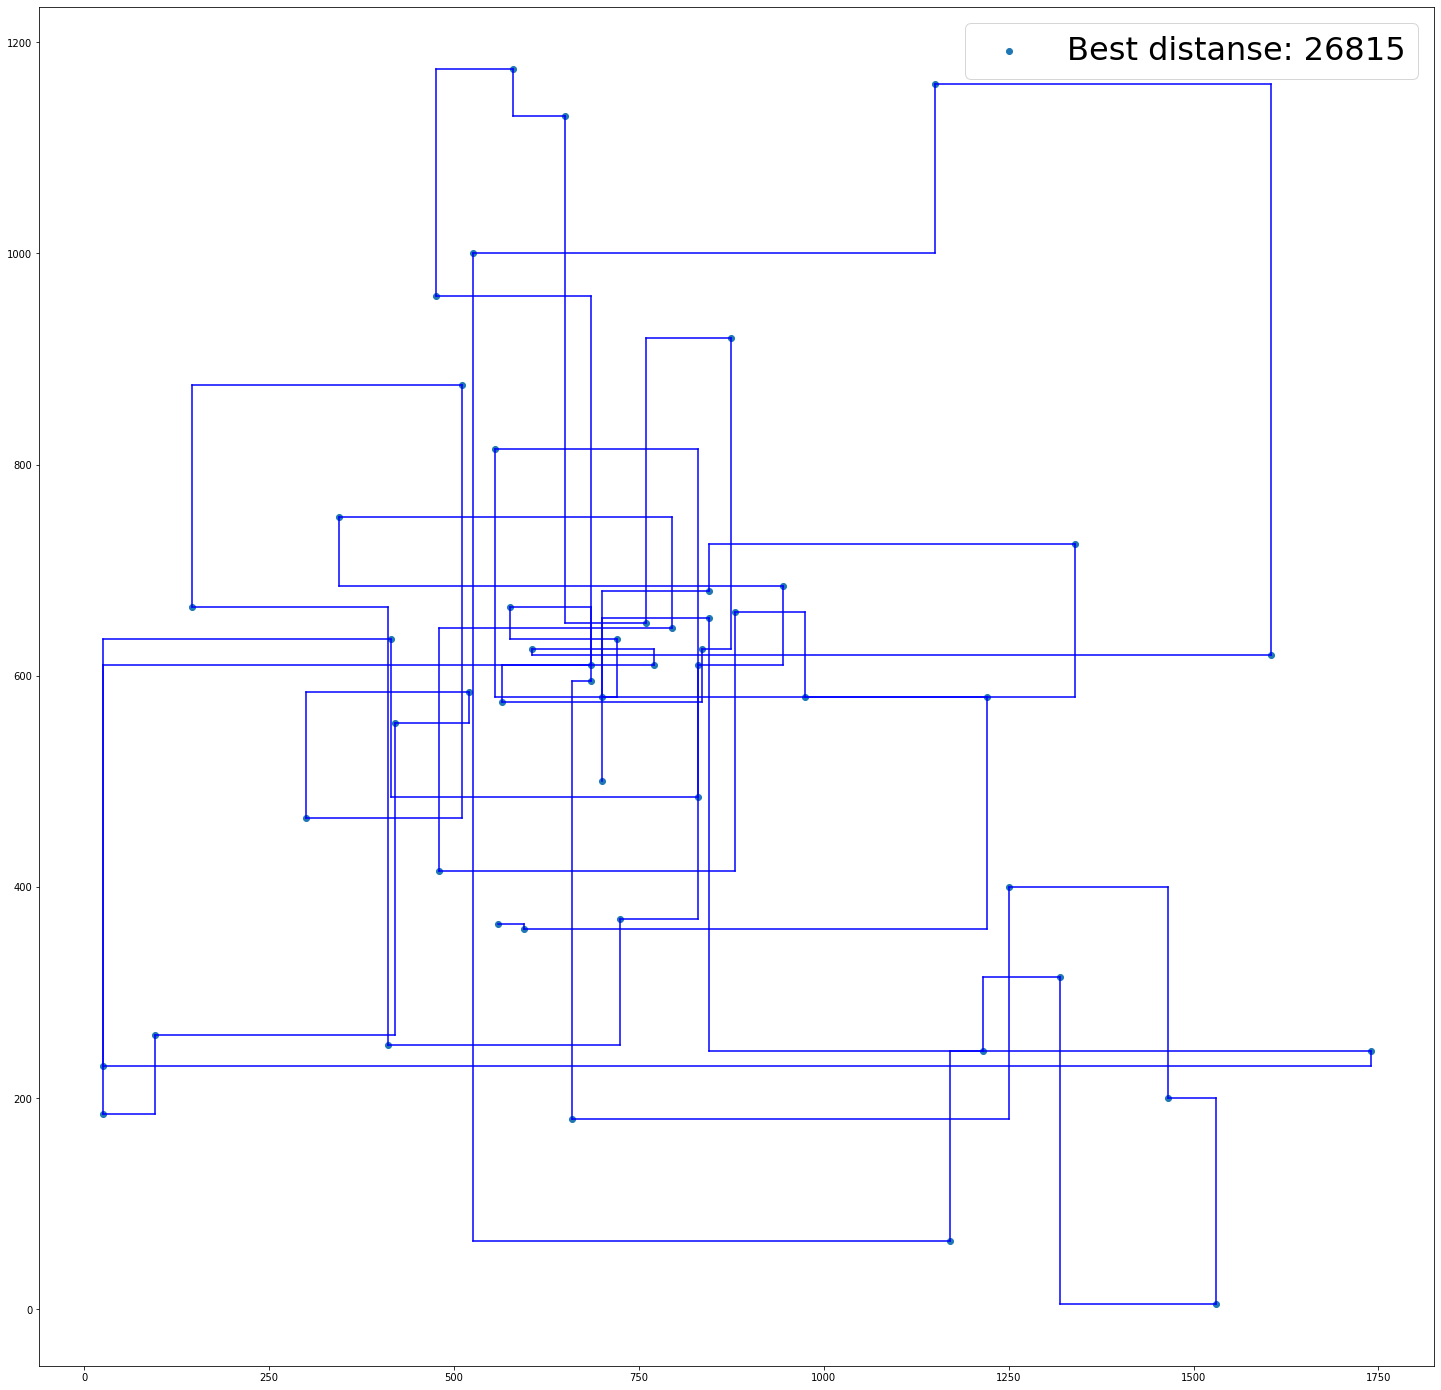

In [172]:
plot_solution(way, score)

### Поиск случайным блужданием

In [192]:
way, score = random_search(10**4)

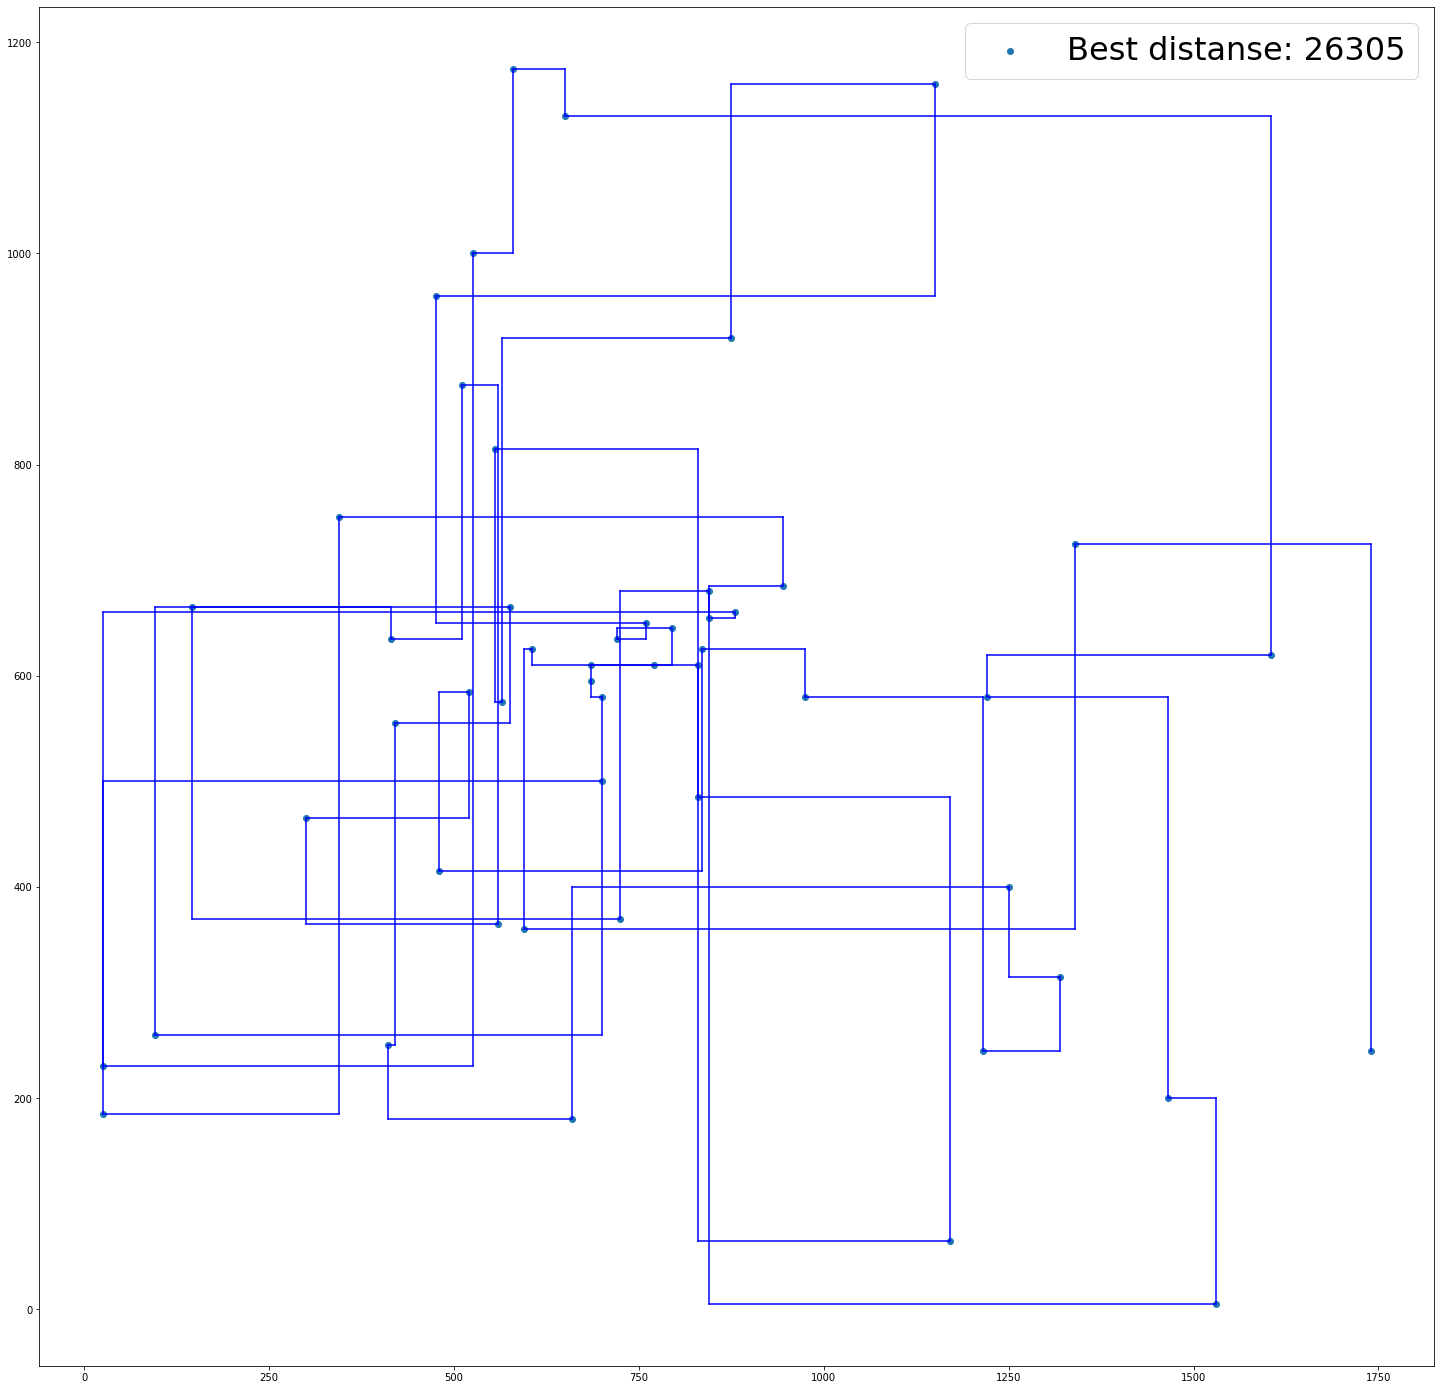

In [193]:
plot_solution(way, score)

### Hill Climb

In [173]:
way, score = hill_climb(1000)

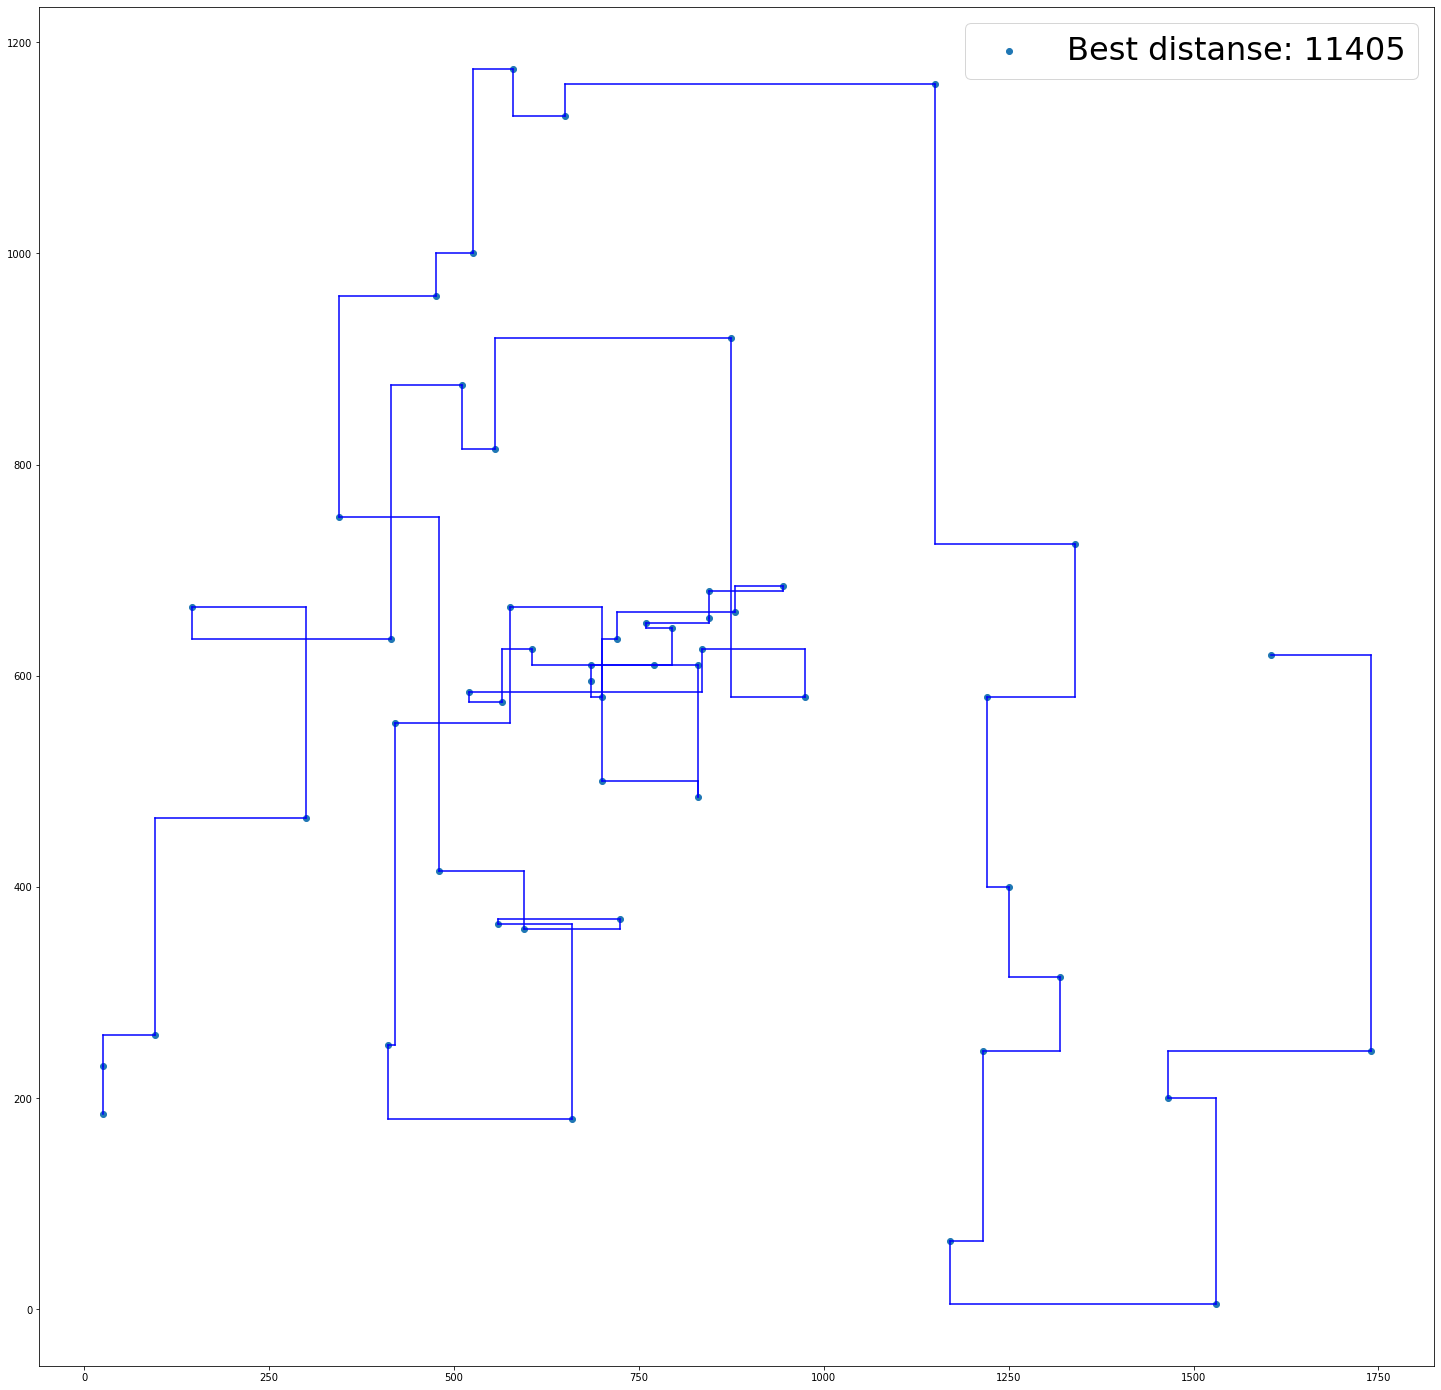

In [174]:
plot_solution(way, score)

### Алгоритм имитации отжига

In [227]:
way, score = annealing(10**4)

### 1. 1000 шагов

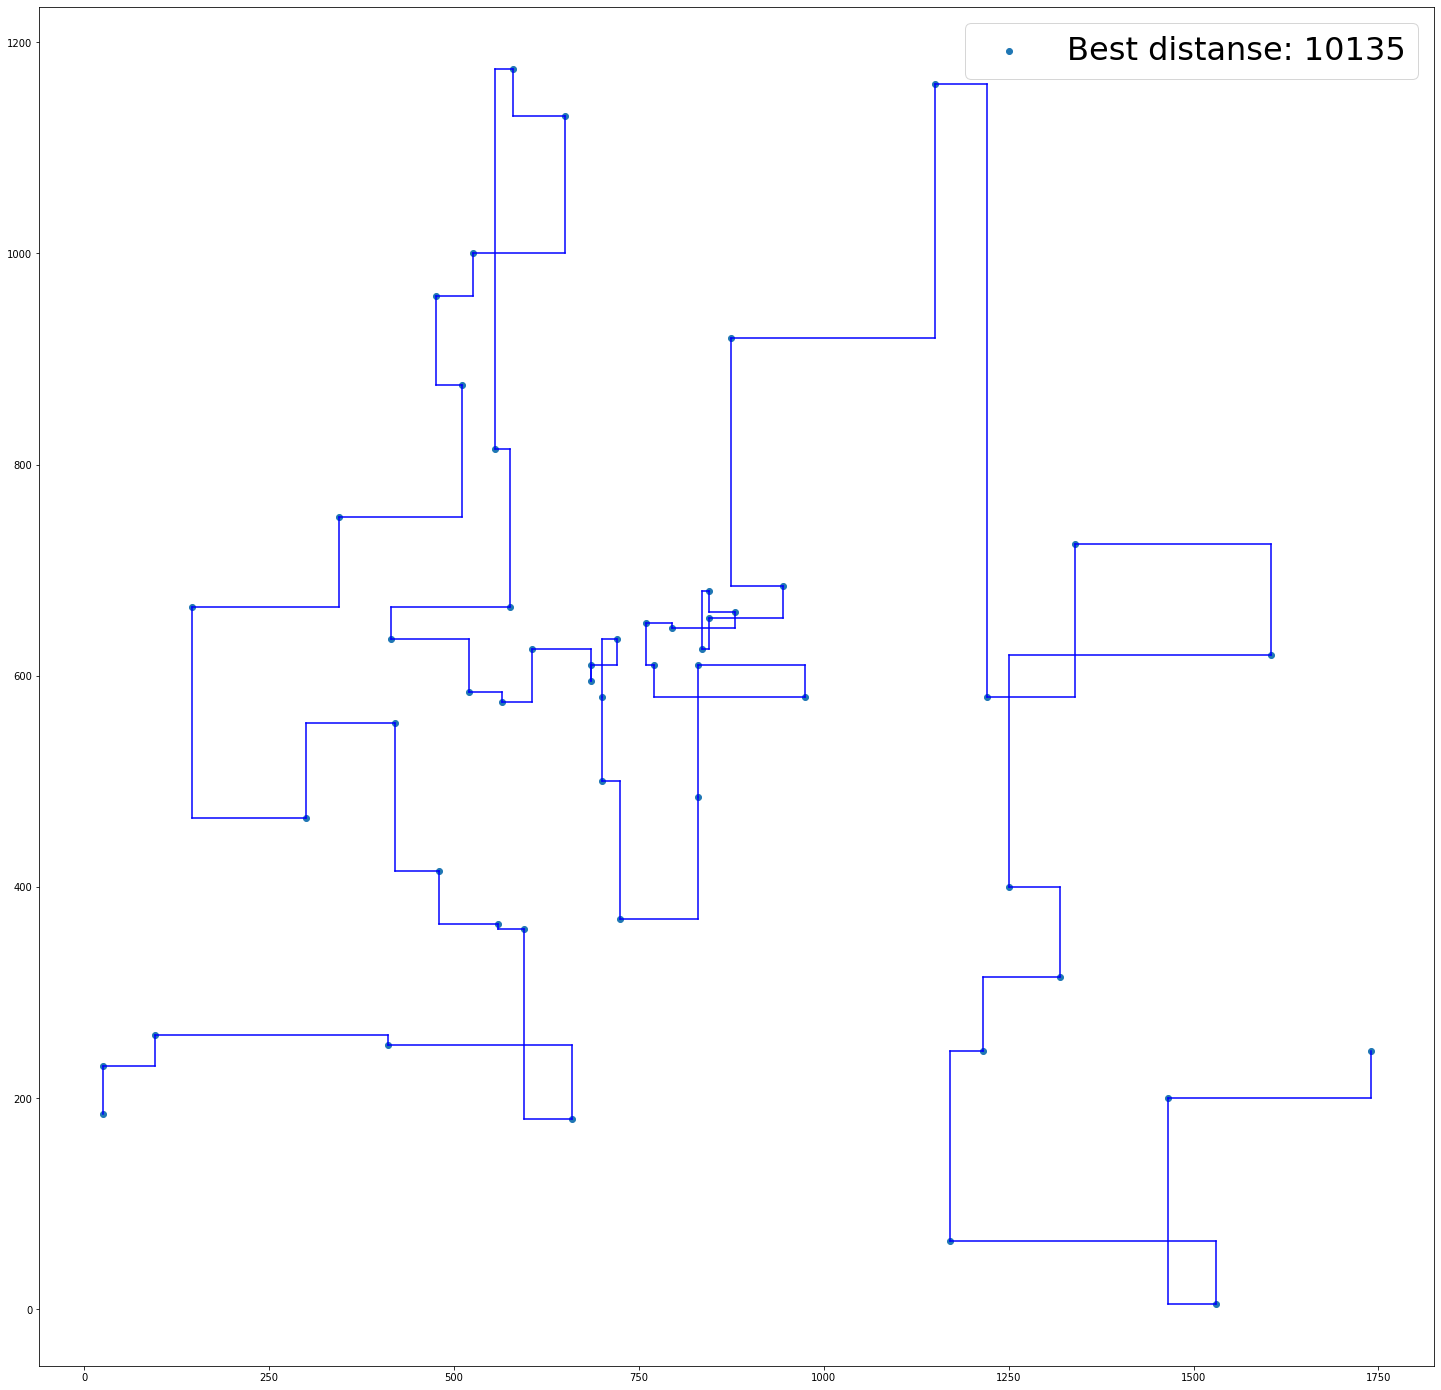

In [226]:
plot_solution(way, score)

### 2.    1 000 000 шагов

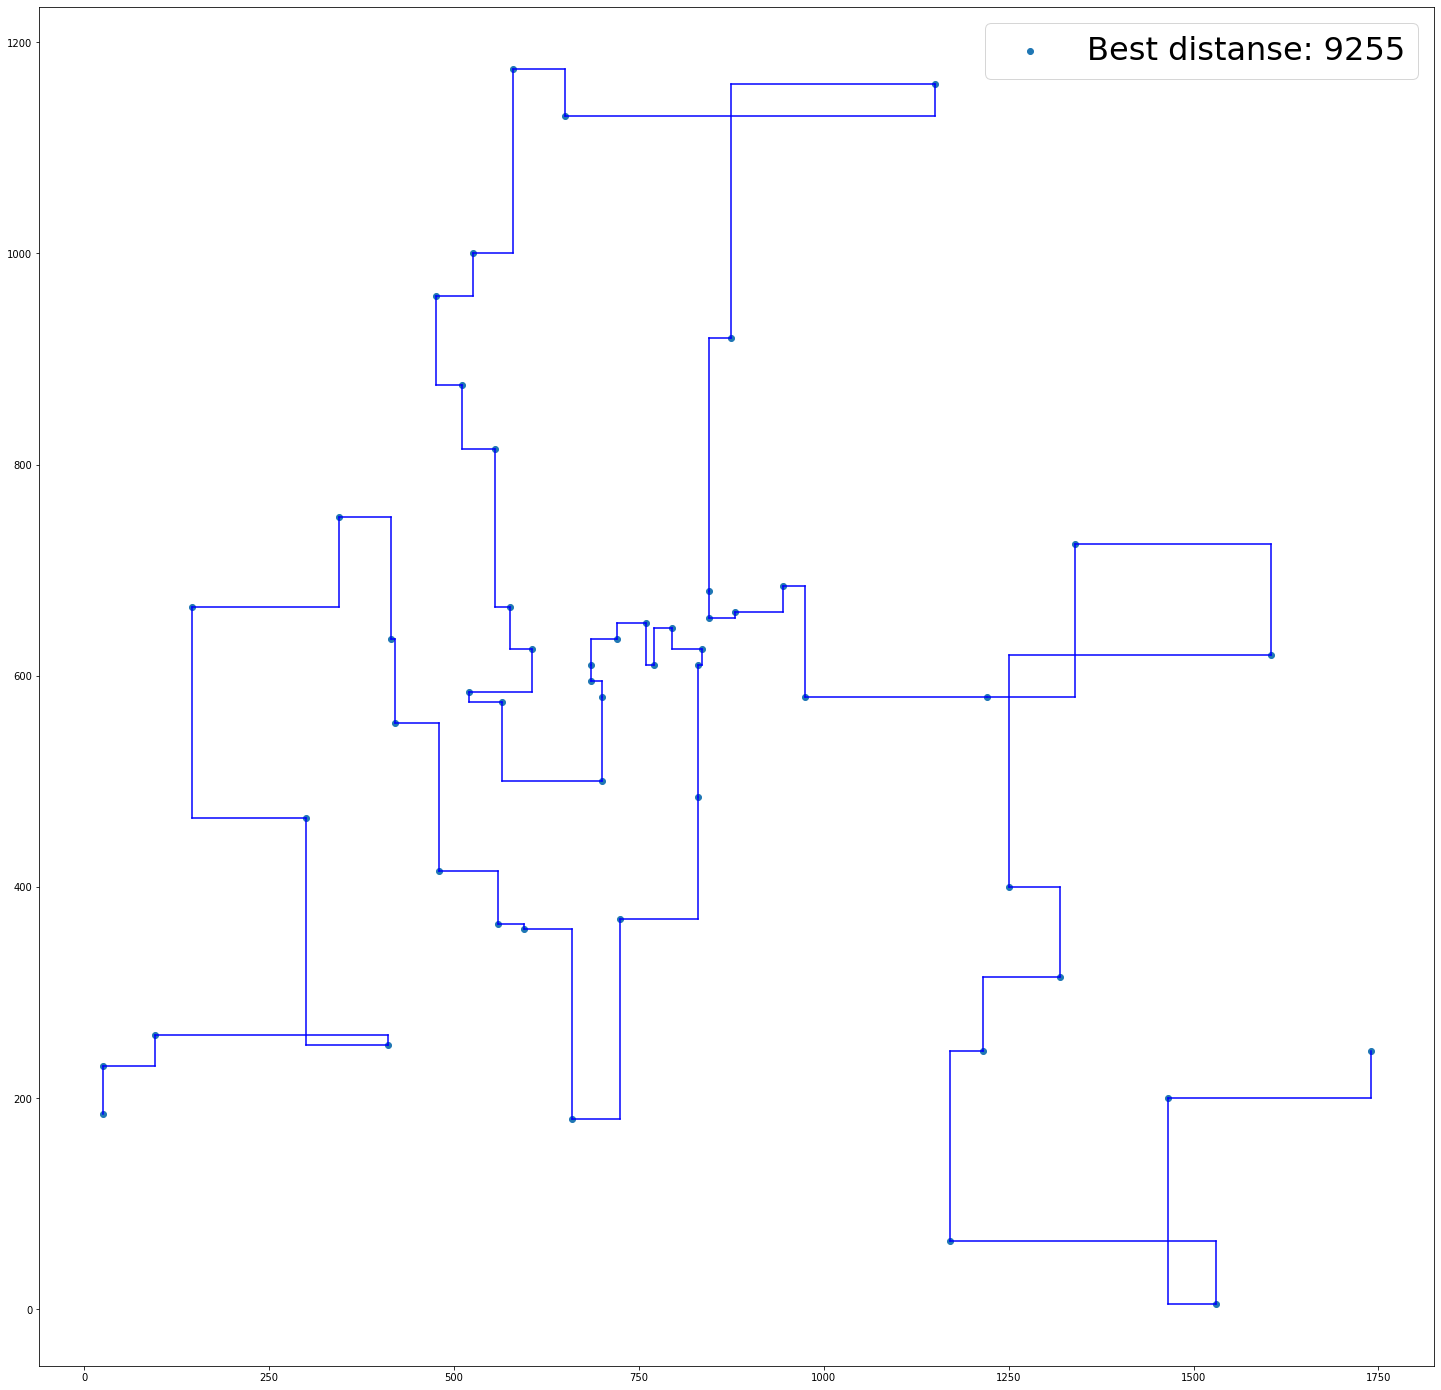

In [228]:
plot_solution(way, score)

### 3. 10 000 000 шагов

In [229]:
way, score = annealing(10**7)

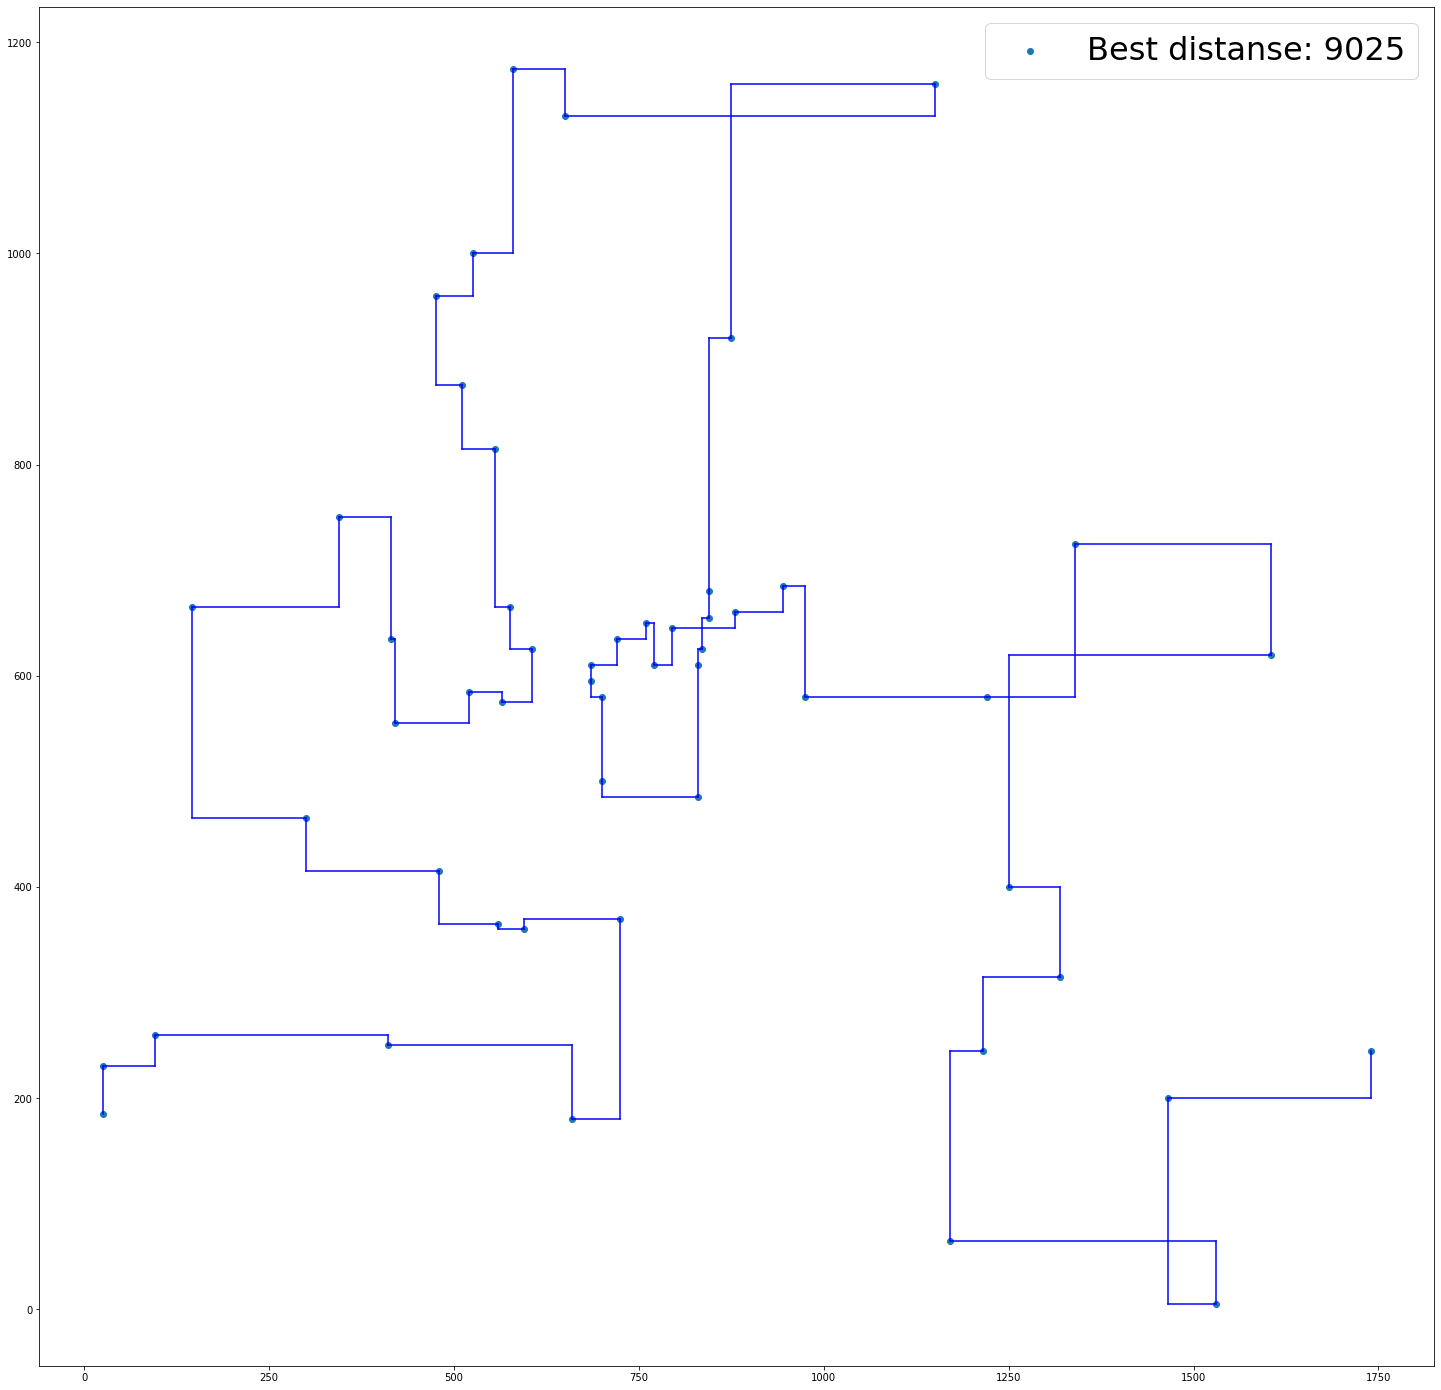

In [231]:
plot_solution(way, score)

### Генетический алгоритм

In [43]:
score, way = genetic(1000)

### 100 поколений

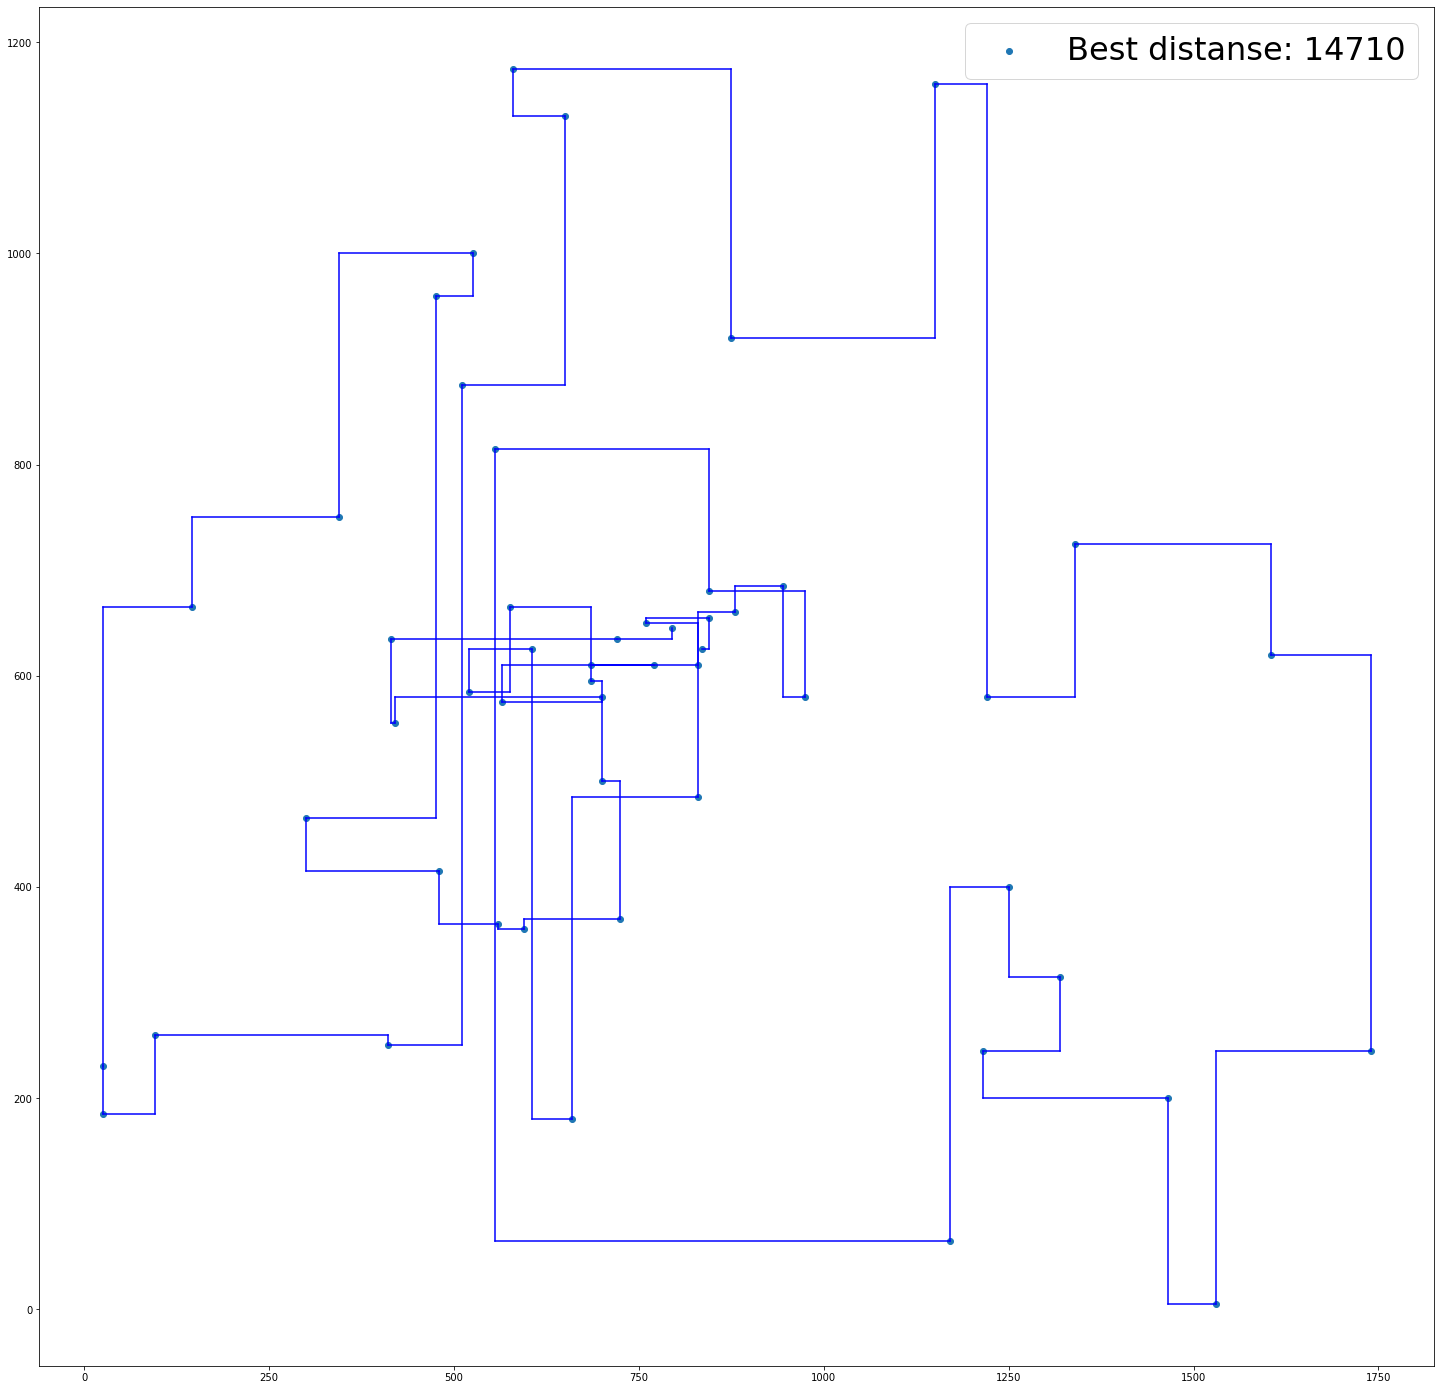

In [32]:
plot_solution(way[[calc_dist(ind) for ind in way].index(min([calc_dist(ind) for ind in way]))], min([calc_dist(ind) for ind in way]))

### 1000 поколений

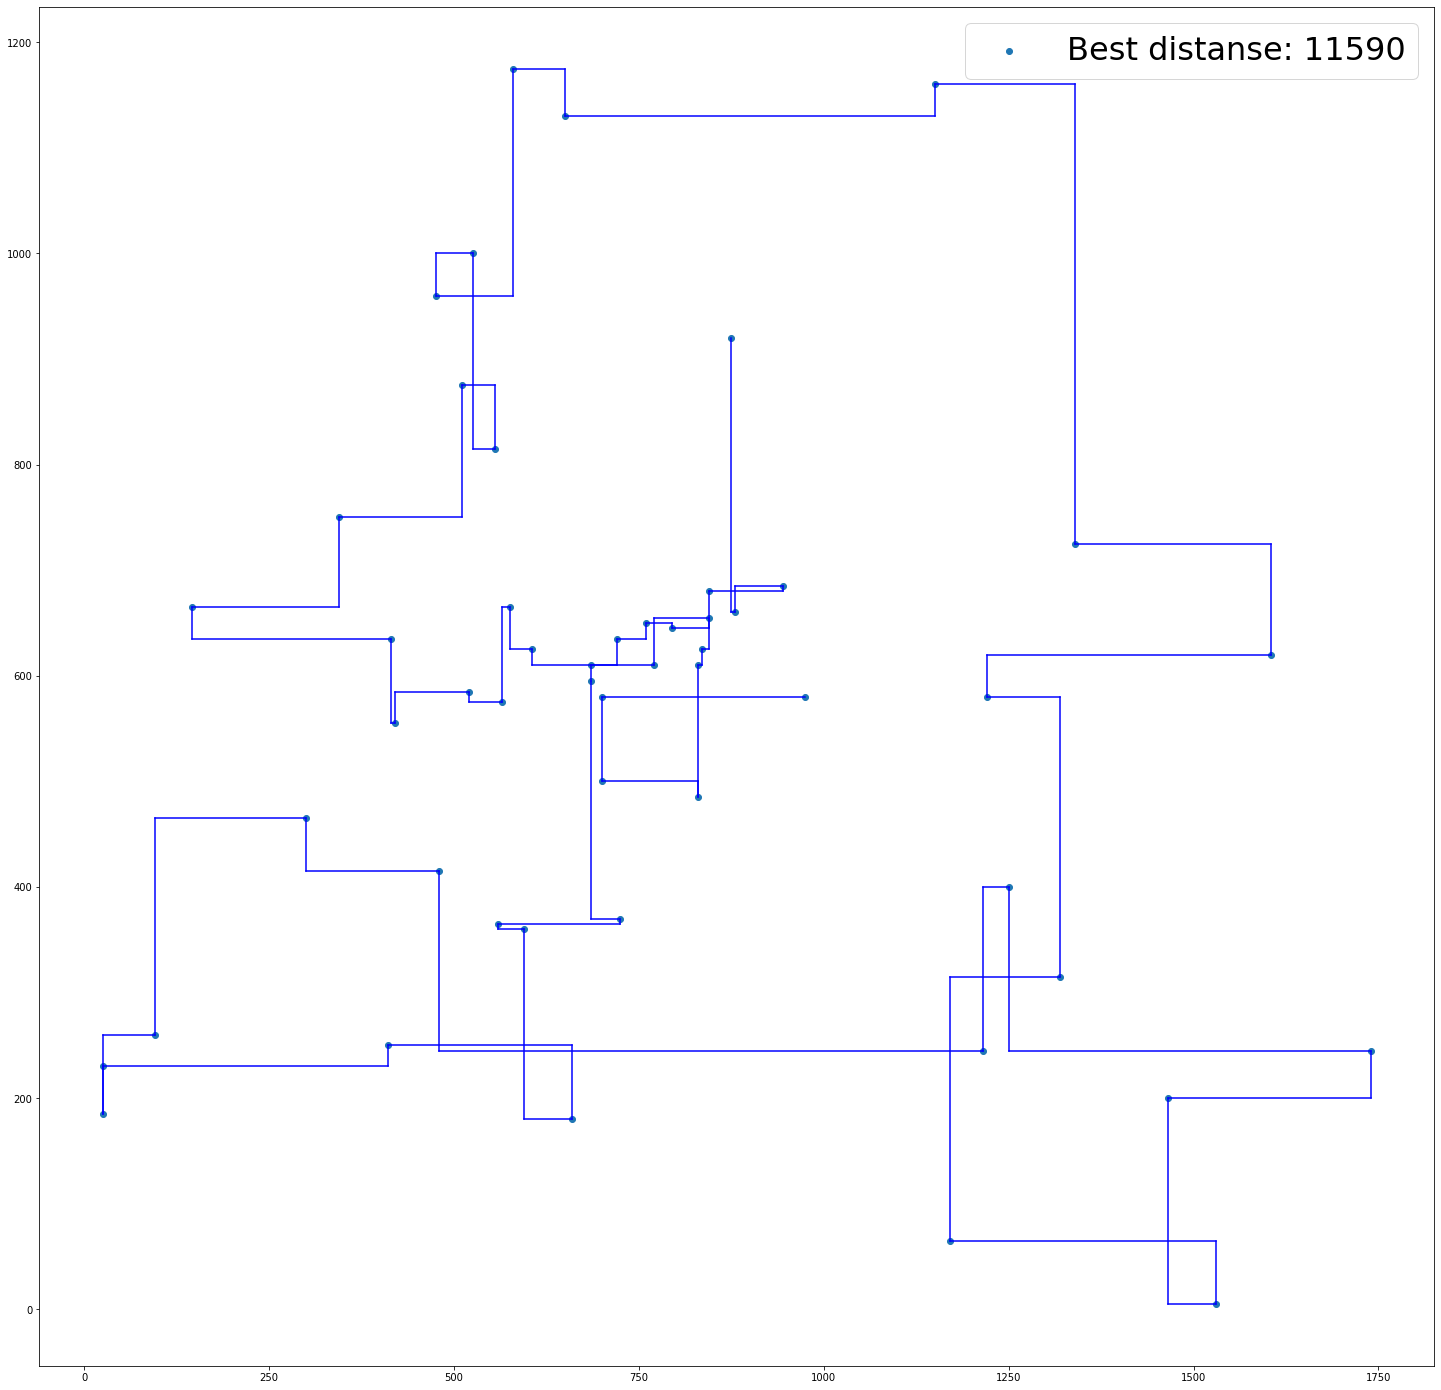

In [44]:
plot_solution(way, score)